In [1]:
import numpy as np
import pandas as pd
import os
import glob
import json

/tmp/ipykernel_1016034/1496302575.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
## use custom cross val values ! could also be done in train test

In [22]:
#models_dir = '/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/'
models_dir = '/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/'

In [23]:
# volume
dataset = 'ukb40_volume'
label = 'volume'
metric = 'cv_score'
embd_type = 'random'

In [ ]:
# FIP
dataset = 'Right_FIP'
label = 'Right_FIP'
metric = 'cv_score'
embd_type = 'custom'

In [ ]:
# SOr
dataset = 'Left_OFC'
label = 'Left_OFC'
metric = 'cv_score'
embd_type = 'custom'

In [ ]:
# Cingulate
dataset = 'Right_PCS'
label = 'Right_PCS'
metric = 'cv_score'
embd_type = 'custom'

In [ ]:
# Sc-sylv
dataset = 'Isomap_central_left'
label = 'Isomap_central_left'
metric = 'cv_score'
embd_type = 'custom'

In [24]:
keywords = ['_left', '_right']
all_matches = []
for var in keywords:
    pattern = f"{models_dir}*{var}/*/{dataset}_{embd_type}_embeddings/{label}*/test_values.json" ## TODO : Make sure only one model per region, take highest epoch, and print
    matches = glob.glob(pattern)
    all_matches.extend(matches)
# Optional: remove duplicates
json_dirs = list(set(all_matches))
json_dirs.sort()

In [25]:
region_list = []
value_list = []
for dir in json_dirs:
    # Get the model name from the directory path
    region = dir.split(models_dir)[1].split('/')[0]  
    # Load the JSON file
    with open(dir, 'r') as f:
        data = json.load(f)
    value = data[metric]
    region_list.append(region)
    value_list.append(value)

In [26]:
## if multiple values per region, take the average
df_value = pd.DataFrame({'region': region_list, 'value': value_list})
df_value = df_value.groupby('region').agg({'value': 'mean'}).reset_index()
df_value = df_value.sort_values(by='value', ascending=False)
df_value = df_value.reset_index(drop=True)

In [27]:
df_value

,region,value
0,FColl-SRh_right,0.350686
1,STi-SOTlat_right,0.310758
2,FPO-SCu-ScCal_right,0.281361
3,ScCal-SLi_right,0.280280
4,fronto-parietal_medial_face_right,0.272513
5,SOr-SOlf_right,0.265972
6,FCLp-subsc-FCLa-INSULA_right,0.265624
7,OCCIPITAL_right,0.230881
8,SOr_right,0.218619
9,STi-STs-STpol_right,0.216351


In [28]:
len(df_value)

29

Text(0.5, 0, 'Score')

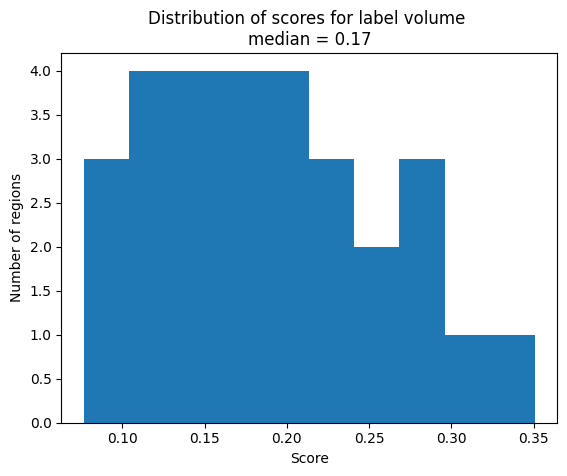

In [29]:
import matplotlib.pyplot as plt
plt.hist(df_value['value'])
plt.title(f'Distribution of scores for label {label} \nmedian = {df_value["value"].median():.2f}')
plt.ylabel('Number of regions')
plt.xlabel('Score')

In [30]:
print(f"mean : {df_value['value'].mean()}, median : {df_value['value'].median()}")

mean : 0.1873236595584337, median : 0.16793834426806115


In [113]:
df_value.to_csv(os.path.join(models_dir, f"all_models_{dataset}_{label}_{metric}.csv"), index=False)

# Try to pred patterns from best regions

It does not improve compared to single region, meaning that there is no supplementary information outside.

In [332]:
n_regions = 10
# Get the top n regions
best_regions = df_value['region'][:n_regions]

In [333]:
best_regions

0    Lobule_parietal_sup_right
1                    FIP_right
2                     FIP_left
3                  STsbr_right
4     Lobule_parietal_sup_left
5              ScCal-SLi_right
6              FColl-SRh_right
7          FPO-SCu-ScCal_right
8             SsP-SPaint_right
9             FCMpost-SpC_left
Name: region, dtype: object

In [334]:
# load embeddings
from tqdm import tqdm
embd_list = []
for i, region in enumerate(best_regions):
    # Load the JSON file
    embds = pd.read_csv(glob.glob(os.path.join(models_dir, region, "*", f"{dataset}_custom_embeddings", f"custom_cross_val_embeddings.csv"))[0])
    embds.columns = ['ID'] + [f'dim_{i}_{j}' for j in range(embds.shape[1]-1)]
    embd_list.append(embds)
## merge all the dfs
print('Merging the embeddings...')
embd = embd_list[0]
for i in tqdm(range(1, len(embd_list))):
    embd = pd.merge(embd, embd_list[i], on='ID', how='outer')

Merging the embeddings...


100%|██████████| 9/9 [00:00<00:00, 139.61it/s]


In [335]:
# load the labels
labels = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/hcp/FIP/FIP_labels.csv')
labels.columns = ['ID'] + labels.columns[1:].tolist()
embd_with_labels = embd.merge(labels, on='ID', how='inner')

In [336]:
Y = embd_with_labels[label].to_numpy()
# keep only the columns whose name starts with 'dim'
X = embd_with_labels.loc[:, embd_with_labels.columns.str.startswith('dim')].to_numpy()

In [337]:
print(Y.shape, X.shape)

(313,) (313, 2560)


In [338]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

In [339]:
splits_basedir = '/neurospin/dico/data/deep_folding/current/datasets/hcp/FIP/Right/train_val_split_'
subjects = embd_with_labels['ID'].to_numpy()
root_dir = '/'.join(splits_basedir.split('/')[:-1])
basedir = splits_basedir.split('/')[-1]
splits_dirs = [os.path.join(root_dir,f) for f in os.listdir(root_dir) if f.startswith(basedir) and '.csv' in f]
splits_subs = [pd.read_csv(file, header=None) for file in splits_dirs]
labels = np.concatenate([[i] * len(K) for i, K in enumerate(splits_subs)])
splits_subs_and_labels = pd.concat(splits_subs)
splits_subs_and_labels.columns=['ID']
splits_subs_and_labels['labels'] = labels
subs_embeddings = pd.DataFrame({'ID': subjects, 'X': list(X), 'Y': Y})
df = subs_embeddings.merge(splits_subs_and_labels, on='ID')
groups, X, Y = df['labels'], np.vstack(df['X'].values), df['Y']
logo = LeaveOneGroupOut()
cv = [*(logo.split(X, Y, groups=groups))]

In [340]:
parameters={'l1_ratio': np.linspace(0,1,11), 'C': [10**k for k in range(-3,4)]}
model = LogisticRegression(solver='saga', penalty='elasticnet', random_state=42)
clf = GridSearchCV(model, parameters, cv=cv, scoring='roc_auc_ovr_weighted', refit=True, n_jobs=-1)

In [341]:
clf.fit(X,Y)
print(f'best params : {clf.best_params_}')
print(f'best score : {clf.best_score_}')

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/volatile/jl277509/Runs/02_STS_babies/Program/2023_j

best params : {'C': 0.001, 'l1_ratio': 0.30000000000000004}
best score : 0.8127628797151442


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
